In [49]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import FastICA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier



In [50]:
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230519_zikken'
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230529_1_zikken'
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230620_zikken'
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230622_zikken'
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230713'


# filePath = 'G:/マイドライブ/実験データ/20230519_zikken'
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']



motor_brainAdress = [9,10,11,12,13,17,18,31,44,45,46,47,48,49,50,54,55]




# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data = list()
label_data = list()#labelを結合したデータ


All_data = list()  # 全データを結合

def Standardization(data): #標準化
    after_data = scipy.stats.zscore(data)
    #b = np.average(after_data)
    #c = np.var(after_data)
    return after_data

file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
['EEG_grasping_13-Jul-2023_sub1-1.mat', 'EEG_grasping_13-Jul-2023_sub1-2.mat', 'EEG_grasping_13-Jul-2023_sub2-1.mat', 'EEG_grasping_13-Jul-2023_sub2-3.mat', 'EEG_grasping_13-Jul-2023_sub2-4.mat', 'EEG_grasping_13-Jul-2023_sub3-1.mat', 'EEG_grasping_13-Jul-2023_sub3-2.mat', 'EEG_grasping_13-Jul-2023_sub3-3.mat', 'EEG_grasping_13-Jul-2023_sub3-4.mat', 'EEG_grasping_13-Jul-2023_sub2-2.mat']


In [51]:
#解析するデータを選択
#file_name1 = [file_name[6],file_name[7],file_name[8],file_name[9]]
file_name1 = [file_name[5],file_name[6],file_name[7],file_name[8]]
file_num1 = len(file_name1)
trial_num = 30
all_trial = len(file_name1) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
print("image data_loading")
print(file_name1)

image data_loading
['EEG_grasping_13-Jul-2023_sub3-1.mat', 'EEG_grasping_13-Jul-2023_sub3-2.mat', 'EEG_grasping_13-Jul-2023_sub3-3.mat', 'EEG_grasping_13-Jul-2023_sub3-4.mat']


In [52]:
c1 = o_data65_label1[0].eeg[0:64 , 0:10240]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[0:64 , 0:10240]
    c1 = np.dstack([c1, g1])
all_data = c1.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)

(120, 64, 10240)


In [53]:
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('biosemi64')
data = mne.EpochsArray(all_data,info=info)

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 7680 out of 7680 | elapsed:    3.3s finished


Selecting by number: 20 components
Fitting ICA took 25.9s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


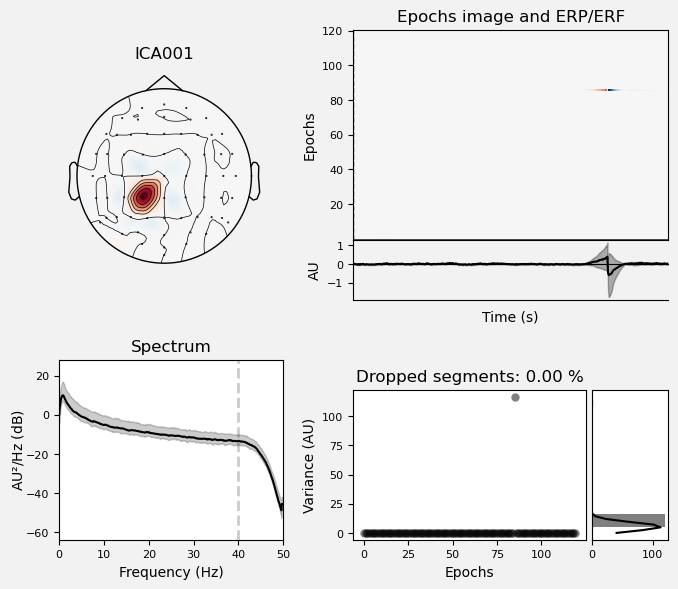

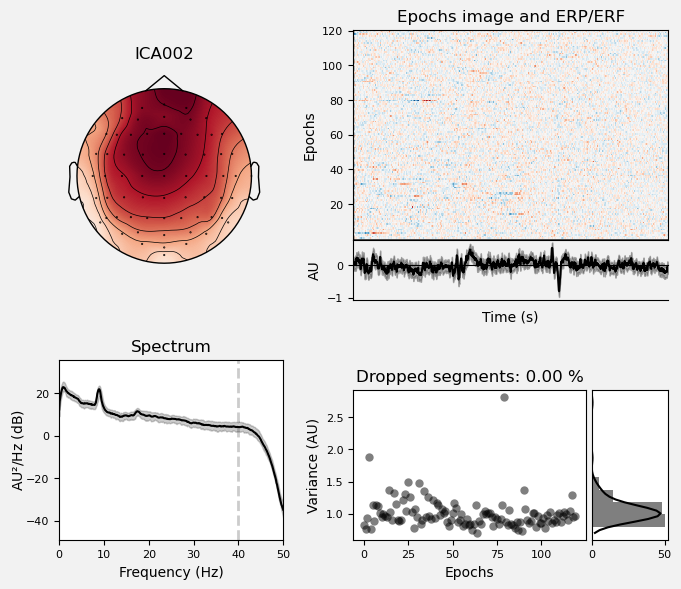

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [54]:
data_flit = data.filter(l_freq=1.0,h_freq=40)
ica = mne.preprocessing.ICA(n_components=20,random_state=42,max_iter='auto')
ica.fit(data_flit)
ica.exclude = [1,2]
ica.plot_properties(data_flit,picks=ica.exclude)

In [55]:
data_ica = data.copy()
ica.apply(data_ica)

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


Number of events,120
Events,1: 120
Time range,0.000 – 9.999 sec
Baseline,off


In [56]:
data_ICA_flit = data_ica.get_data()

In [57]:
np.shape(data_ICA_flit)

(120, 64, 10240)

In [58]:
filter_bandpass = signal.firwin(numtaps=51,cutoff=[6,40],fs = 1024,pass_zero=False)
task_kind = 2
par_task = 60
CH = 64
# for n in range(task_kind):
#     for j in range(par_task):
#         for k in range(CH):
#             data_ICA_flit[n*60+j][k]= abs(data_ICA_flit[n*60+j][k]-np.mean(data_ICA_flit[n*60+j][0:64],axis=0))
#             data_ICA_flit[n*60+j][k] = signal.lfilter(filter_bandpass,1,data_ICA_flit[n*60+j][k])
#             all_data[n*60+j][k] = scipy.stats.zscore(data_ICA_flit[n*60+j][k])

In [59]:
label_data = list()#labelを結合したデータ
for n in range(all_trial):
    label_data.append(o_data65_label1[n].label)
print(label_data)
print(np.shape(label_data))

[1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1]
(120,)


In [60]:
#numpy配列の定義
task1 = o_data65_label1[0].eeg[: , 0:10240]
task2 = o_data65_label1[0].eeg[: , 0:10240]
for n in range(all_trial):
    if label_data[n] == 1:
        join = data_ICA_flit[n,: , 0:10240]
        task1 = np.dstack([task1, join])
    if label_data[n] == 2:
        join = data_ICA_flit[n,: , 0:10240]
        task2 = np.dstack([task2, join])
#task1低速度
task1_data = task1.transpose(2,0,1)
task1_data = task1_data.astype(np.double)
task1_data = np.delete(task1_data,0,axis=0)
print(np.shape(task1_data))
#task2低速度
task2_data = task2.transpose(2,0,1)
task2_data = task2_data.astype(np.double)
task2_data = np.delete(task2_data,0,axis=0)
print(np.shape(task2_data))

(60, 64, 10240)
(60, 64, 10240)


In [61]:
processed_task1 = task1_data[:,range(64),1024*6:1024*10]
processed_task2 = task2_data[:,range(64),1024*6:1024*10]
class_data = np.concatenate([processed_task1,processed_task2])
class_label = np.zeros(120,dtype=int)
class_label[60:] = 1

In [62]:
np.shape(class_data)

(120, 64, 4096)

In [63]:
#時系列データのSVM
class_data_reshape = np.reshape(class_data,(120,64*1024*4))
X_train, X_test, Y_train, Y_test = train_test_split(class_data_reshape,class_label, test_size=0.25,random_state=42)
model =SVC(kernel='linear')
model.fit(X_train,Y_train)
print(model.score(X_test, Y_test))

0.5333333333333333


In [64]:
CSPtrain, SVMtrain, CSPlabel, SVMlabel = train_test_split(class_data,class_label, test_size=0.6,random_state=42)


In [65]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=2, log=None, reg=None)
csp = CSP(n_components=8, reg=None, norm_trace=False, transform_into='csp_space',cov_est='epoch')

In [66]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(CSPtrain, CSPlabel)
csp.plot_patterns(info,ch_type='eeg', units='None', size=1.5)

Computing rank from data with rank=None


    Using tolerance 1.3e+02 (2.2e-16 eps * 64 dim * 9.2e+15  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 64 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 91 (2.2e-16 eps * 64 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 64 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 64 dim * 9.9e+15  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 64 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating covariance using EMPIRICAL
Done

LinAlgError: The leading minor of order 64 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [ ]:
class_data_cspfit = csp.transform(SVMtrain)
print(np.shape(class_data_cspfit))

(72, 8, 4096)


In [ ]:
class_data_cspfit = np.reshape(class_data_cspfit,(72,8*4096))
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(class_data_cspfit,SVMlabel, test_size=0.25,random_state=42)
model =SVC(kernel='linear')
model.fit(X_train2,Y_train2)
print(model.score(X_test2, Y_test2))

0.3888888888888889


In [ ]:
params = {
    "C":np.logspace(-2,10,13),
    "kernel":[ "linear", "rbf", "sigmoid"],
    "gamma":np.logspace(-9,3,13)
}
grid = GridSearchCV(model, params,scoring="accuracy", cv=5)

grid.fit(X_train2, Y_train2)

print("grid_best_score=",grid.best_score_)
print(grid.best_params_)

pred = grid.predict(X_test2)
print(classification_report(Y_test2, pred))

grid_best_score= 0.5909090909090909
{'C': 10.0, 'gamma': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.30      0.27      0.29        11
           1       0.00      0.00      0.00         7

    accuracy                           0.17        18
   macro avg       0.15      0.14      0.14        18
weighted avg       0.18      0.17      0.17        18



In [ ]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

%matplotlib inline

In [ ]:
#PCAを用意
pca = PCA(n_components=2)
#PCAで次元圧縮
pca.fit(X_train2)
#PCAの結果を元にデータを変換
pca_X = pca.transform(X_train2)

Text(0, 0.5, 'x2')

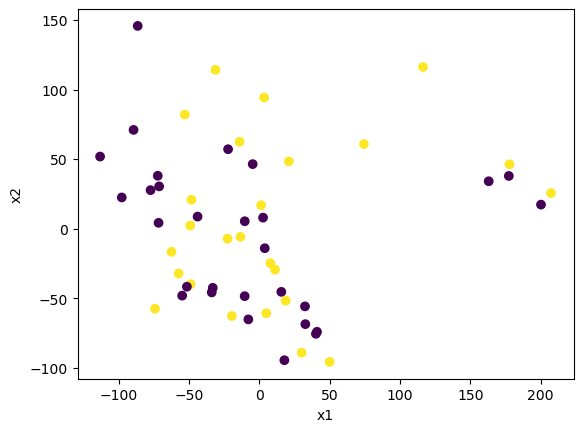

In [ ]:
#SVNデータの点を表示
Z = grid.predict(X_train2)

plt.scatter(pca_X[:,0], pca_X[:,1], c=Z)
plt.xlabel("x1")
plt.ylabel("x2")